In [355]:
import numpy as np

import torch
import torchsde

import matplotlib.pyplot as plt

from src.springs_plot import generalized_animation
from src.speed_springs import GGS3DE

import sympy as sp

In [356]:
torch.manual_seed(0)
u_i = torch.linspace(0, 2*torch.pi, 20).reshape(1, -1)
# y_i = torch.sin(u_i) + 0.1*torch.randn_like(u_i)
y_i = 2*u_i + 0.1*torch.randn_like(u_i)

dof = 1
batch_size, state_size, t_size = 1000, (dof+1)*2, 1000
sde = GGS3DE(dof, u_i, y_i, friction=1, temp=1, k=1e-16, M=1e-16)

ts = torch.linspace(0, 100, t_size)
y0 = torch.rand(size=(batch_size, state_size))

with torch.no_grad():
    ys_gen = torchsde.sdeint(sde, y0, ts, method='euler')  # (t_size, batch_size, state_size)

Creating symbols...
Calculating kinetic energy...
Iterating over 2 dimensions
Calculating kinetic energy for dimension 0...
Calculating rotational kinetic energy...
Calculating rotational kinetic energy for dimension 0...
Calculating potential energy...
Calculating potential energy for point 0...
Calculating potential energy for point 1...
Calculating potential energy for point 2...
Calculating potential energy for point 3...
Calculating potential energy for point 4...
Calculating potential energy for point 5...
Calculating potential energy for point 6...
Calculating potential energy for point 7...
Calculating potential energy for point 8...
Calculating potential energy for point 9...
Calculating potential energy for point 10...
Calculating potential energy for point 11...
Calculating potential energy for point 12...
Calculating potential energy for point 13...
Calculating potential energy for point 14...
Calculating potential energy for point 15...
Calculating potential energy for poi

KeyboardInterrupt: 

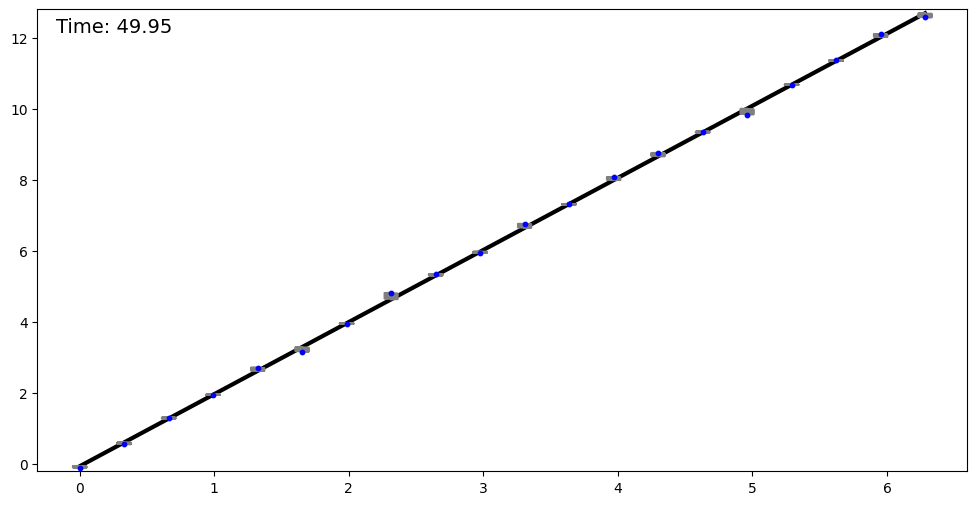

In [343]:
generalized_animation(ts, ys_gen[:,0,:], np.array(u_i.flatten()), np.array(y_i.flatten()), path='anis/speed_ggs3de2.gif')

(array([1.e-19, 1.e-18, 1.e-17, 1.e-16, 1.e-15, 1.e-14, 1.e-13, 1.e-12]),
 [Text(0, 1e-19, '$\\mathdefault{10^{-19}}$'),
  Text(0, 1e-18, '$\\mathdefault{10^{-18}}$'),
  Text(0, 1e-17, '$\\mathdefault{10^{-17}}$'),
  Text(0, 1e-16, '$\\mathdefault{10^{-16}}$'),
  Text(0, 1e-15, '$\\mathdefault{10^{-15}}$'),
  Text(0, 1e-14, '$\\mathdefault{10^{-14}}$'),
  Text(0, 1e-13, '$\\mathdefault{10^{-13}}$'),
  Text(0, 1e-12, '$\\mathdefault{10^{-12}}$')])

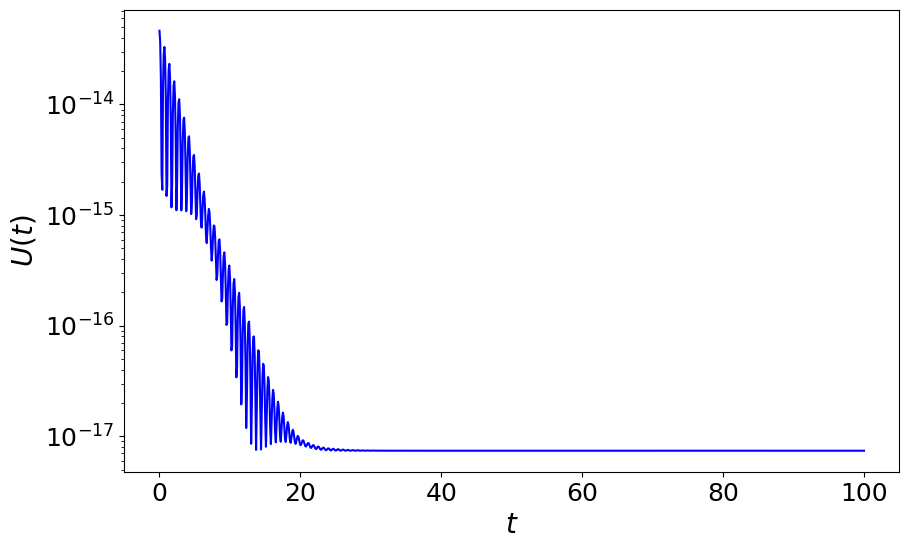

In [358]:
costs = sde.cost(ys_gen[:, 0, :]).detach().numpy()

plt.figure(figsize=(10, 6))
plt.plot(ts, costs, label='Mean Cost', color='blue')
plt.yscale('log')
# plt.fill_between(ts, mean_costs - std_costs, mean_costs + std_costs, color='blue', alpha=0.2)
plt.xlabel(r'$t$', fontsize=20)
plt.ylabel(r'$U(t)$', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [371]:
all_costs = torch.stack([sde.cost(ys_gen[:, i, :]) for i in range(batch_size)], dim=1).detach().numpy()
costs_mean = all_costs.mean(axis=1)

(array([1.e-19, 1.e-18, 1.e-17, 1.e-16, 1.e-15, 1.e-14, 1.e-13, 1.e-12]),
 [Text(0, 1e-19, '$\\mathdefault{10^{-19}}$'),
  Text(0, 1e-18, '$\\mathdefault{10^{-18}}$'),
  Text(0, 1e-17, '$\\mathdefault{10^{-17}}$'),
  Text(0, 1e-16, '$\\mathdefault{10^{-16}}$'),
  Text(0, 1e-15, '$\\mathdefault{10^{-15}}$'),
  Text(0, 1e-14, '$\\mathdefault{10^{-14}}$'),
  Text(0, 1e-13, '$\\mathdefault{10^{-13}}$'),
  Text(0, 1e-12, '$\\mathdefault{10^{-12}}$')])

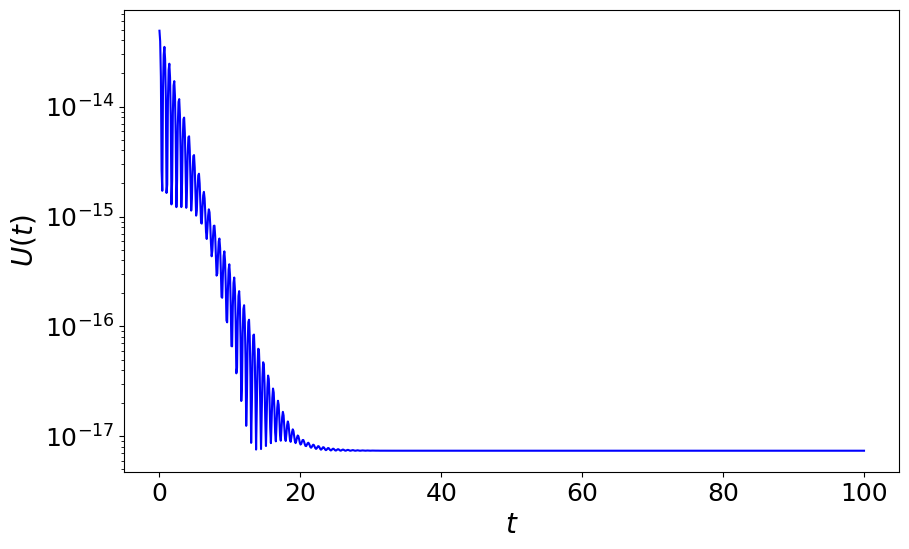

In [372]:
plt.figure(figsize=(10, 6))
plt.plot(ts, costs_mean, label='Mean Cost', color='blue')
plt.yscale('log')
# plt.fill_between(ts, mean_costs - std_costs, mean_costs + std_costs, color='blue', alpha=0.2)
plt.xlabel(r'$t$', fontsize=20)
plt.ylabel(r'$U(t)$', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

## Entropy production

In [373]:
def get_xxt_avg(ys):
    yse = ys[:, :, :, None]
    yse_t = yse.transpose(2, 3)

    xxt = torch.matmul(yse, yse_t)
    xxt_avg = torch.mean(xxt, dim=1)
    return xxt_avg

def get_x_avg(ys):
    return torch.mean(ys, dim=1)

def get_theta(ys):
    xxt_avg = get_xxt_avg(ys)
    x_avg_e = get_x_avg(ys)[:, :, None]
    x_avg_t = x_avg_e.transpose(1, 2)
    return xxt_avg - torch.matmul(x_avg_e, x_avg_t)

def get_Dtensor(diag):
    # turn diag float to tensor
    diag = torch.tensor(diag)
    diag_tensor = torch.diag(diag)
    Dtensor = diag_tensor @ diag_tensor.T / 2
    return Dtensor

def get_Ab(sde):
    minvf = sde.LM.mass_matrix_full.pinv() @ sde.LM.forcing_full
    vecs = sp.Matrix(np.vstack((sde.x_symbols.reshape(-1,1), sde.dx_symbols.reshape(-1,1))))

    n = vecs.shape[0]

    A = np.zeros((minvf.shape[0], n))
    b = np.zeros((minvf.shape[0], 1))

    for i in range(minvf.shape[0]):
        for j in range(n):
            A[i, j] = -minvf[i].coeff(vecs[j])
        b[i] = minvf[i].subs({vi: 0 for vi in vecs})
    return A, b

def get_Abqp(sde):
    A, b = get_Ab(sde)
    n = A.shape[1]

    A_irr = np.zeros_like(A)
    b_irr = np.zeros_like(b)
    A_rev = np.zeros_like(A)
    b_rev = np.zeros_like(b)

    A_irr[:n//2, :n//2] = A[:n//2, :n//2]
    A_irr[n//2:, n//2:] = A[n//2:, n//2:]
    b_irr[:n//2] = b[:n//2]

    A_rev[:n//2, n//2:] = A[:n//2, n//2:]
    A_rev[n//2:, :n//2] = A[n//2:, :n//2]
    b_rev[n//2:] = b[n//2:]
    return A_irr, b_irr, A_rev, b_rev

def getPit(ys, sde):
    theta = get_theta(ys)
    diag = sde.eta_cte * torch.ones(ys.shape[2])
    Dtensor = get_Dtensor(diag)
    # Aq = get_Aq(sde)
    return torch.vmap(torch.trace)(Dtensor @ theta.inverse())

def get_dsdt(ys, sde):
    theta = get_theta(ys)
    diag = sde.eta_cte * torch.ones(ys.shape[2])
    Dtensor = get_Dtensor(diag)
    A, b = get_Ab(sde)

    return torch.vmap(torch.trace)(theta.inverse() @ Dtensor - A)

In [374]:
sde.eta_cte

0.0005254804506354161

In [375]:
pit = getPit(ys_gen, sde)
dsdt = get_dsdt(ys_gen, sde)

# window avg pit
window = 1
pit_avg = torch.zeros_like(pit)
for i in range(window, len(pit)):
    pit_avg[i] = torch.mean(pit[i-window:i])

/var/folders/x9/8zgqvcbx66q2mjvw0wjdx_fw0000gn/T/ipykernel_19031/1572490802.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diag = torch.tensor(diag)


In [382]:
pit.shape

torch.Size([1000])

Text(0, 0.5, '$\\Pi(t)$')

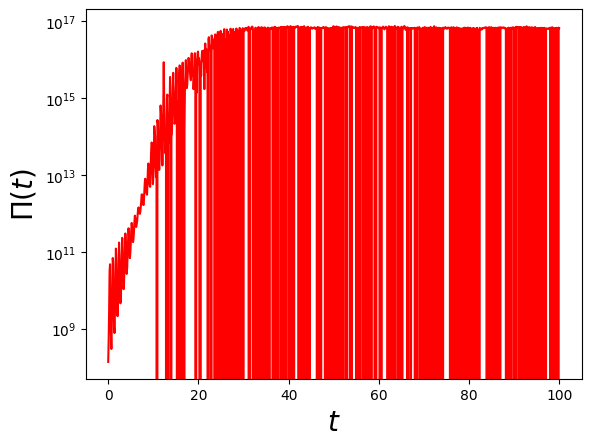

In [383]:
# plt.plot(ts, pit_avg, label='Pi(t)', color='red')
plt.plot(ts, pit/costs_mean, c='red')
# plt.ylim(-0.5, 0.5)
plt.yscale('log')
plt.xlabel(r'$t$', fontsize=20)
plt.ylabel(r'$\Pi(t)$', fontsize=20)

# 2D

In [7]:
np.random.seed(100)

n_pieces = torch.tensor([1,1])
u_i = torch.tensor([[1,2,3,4,5,6], [1,2,3,4,5,6]])

y_i = torch.rand(2,6)

batch_size, state_size, t_size = 2, torch.prod(n_pieces + torch.ones_like(n_pieces))*2*y_i.shape[0], 200
sde = GGS3DE(n_pieces, u_i, y_i, friction=2, temp=1, k=1, M=1)
ts = torch.linspace(0, 20, t_size)

y0 = torch.rand(size=(batch_size, state_size))

with torch.no_grad():
    ys_gen = torchsde.sdeint(sde, y0, ts, method='euler')  # (t_size, batch_size, state_size)

Creating symbols...
Calculating kinetic energy...
Iterating over 3 dimensions
Calculating kinetic energy for dimension 0...
Calculating kinetic energy for dimension 1...
Calculating rotational kinetic energy...
Calculating rotational kinetic energy for dimension 0...
Calculating rotational kinetic energy for dimension 1...
Calculating potential energy...
Calculating potential energy for point 0...
Calculating potential energy for point 1...
Calculating potential energy for point 2...
Calculating potential energy for point 3...
Calculating potential energy for point 4...
Calculating potential energy for point 5...
Calculating Lagrangian...
Done initializing.


In [115]:
ys_gen[:,0,:].shape, u_i.shape, y_i.shape, n_pieces

(torch.Size([200, 8]), torch.Size([2, 6]), torch.Size([1, 6]), tensor([1, 1]))

'anis/speed_3d_11.gif'

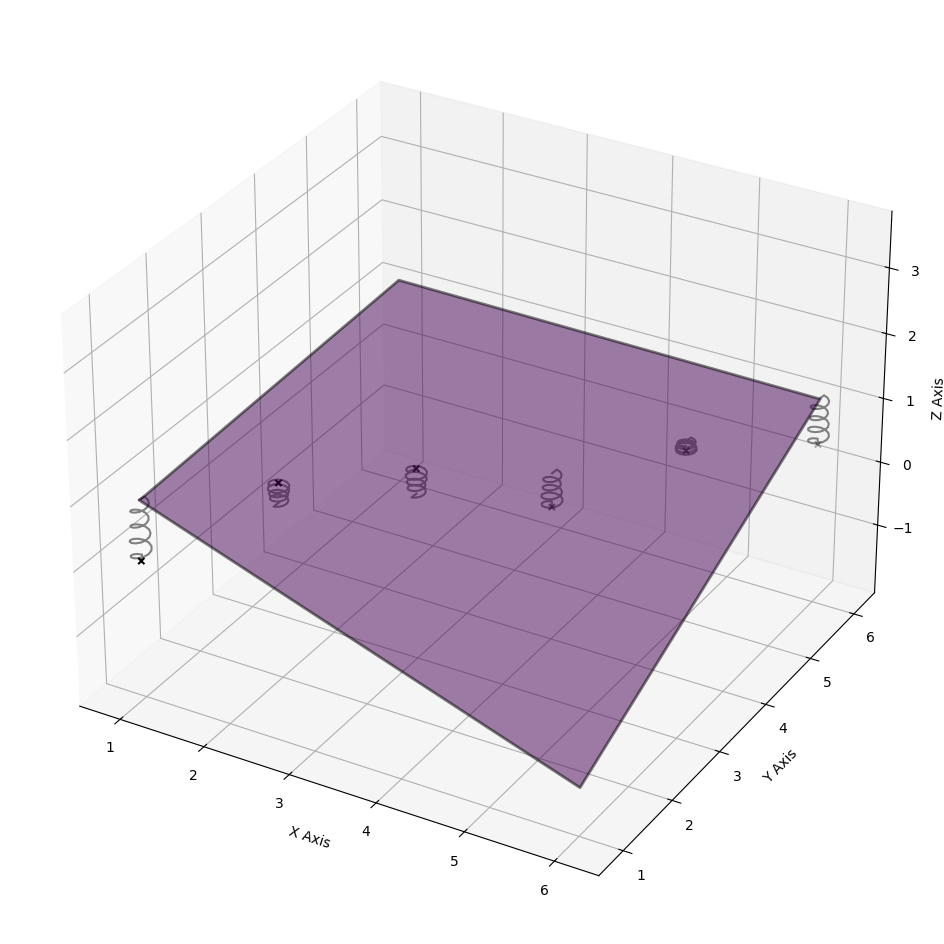

In [118]:
from springs_plot import generalized_animation_3d

generalized_animation_3d(ts, ys_gen[:,0,:], u_i, y_i, np.array(n_pieces + torch.ones_like(n_pieces)), sde, path="anis/speed_3d_11.gif")

# Mnist

In [1]:
import torch
import torchsde
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Number of data points
ndata_train = 20
ndata_test = 20

# Transformations for the dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))]
)

# Load training and test datasets
trainset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=len(trainset), shuffle=True
)

testset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=len(testset), shuffle=True
)

# Get full training data
u_i_train, y_train = next(iter(trainloader))
u_i_test, y_test = next(iter(testloader))

# One-hot encoding of the labels
y_i_train = torch.nn.functional.one_hot(y_train, num_classes=10)
y_i_test = torch.nn.functional.one_hot(y_test, num_classes=10)

print("Preprocessing data...")

# Center and normalize the training data
u_i_train_centered = u_i_train - u_i_train.mean(axis=0)
u_i_train_normalized = u_i_train_centered / (u_i_train_centered.std(axis=0) + 1e-10)

# Apply the same transformation to the test data
u_i_test_centered = u_i_test - u_i_train.mean(axis=0)
u_i_test_normalized = u_i_test_centered / (u_i_train.std(axis=0) + 1e-10)

# Get 4 PCA components of u_i_train
pca = PCA(n_components=4)
u_i_train_pca = torch.tensor(pca.fit_transform(u_i_train_normalized))
u_i_test_pca = torch.tensor(pca.transform(u_i_test_normalized))

# Split the train data into smaller sets
u_i_train_pca_small = u_i_train_pca[:ndata_train, :]
y_i_train_small = y_i_train[:ndata_train, :]

# Split the test data into smaller sets
u_i_test_pca_small = u_i_test_pca[:ndata_test, :]
y_i_test_small = y_i_test[:ndata_test, :]

print("Training data size:", u_i_train_pca_small.shape)
print("Test data size:", u_i_test_pca_small.shape)

/Users/luismantilla/miniforge3/envs/huggingface/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/luismantilla/miniforge3/envs/huggingface/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <6DFB383A-E1D9-3EC6-8A60-382AF4E3C226> /Users/luismantilla/miniforge3/envs/huggingface/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <3FE16EFD-B5EE-33D2-A4C8-2BD93F2AA7BA> /Users/luismantilla/miniforge3/envs/huggingface/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Preprocessing data...
Training data size: torch.Size([20, 4])
Test data size: torch.Size([20, 4])


In [4]:
n_pieces_train = torch.ones_like(u_i_train_pca_small[0], dtype=int)
n_pieces_test = torch.ones_like(u_i_test_pca_small[0], dtype=int)

batch_size = 1

state_size_train = torch.prod(n_pieces_train + 1) * 2 * y_i_train_small.shape[0]
t_size_train = 50

state_size_test = torch.prod(n_pieces_test + 1) * 2 * y_i_test_small.shape[0]
t_size_test = 50

sde_train = GGS3DE(
    n_pieces_train, u_i_train_pca_small.T, y_i_train_small.T, friction=100, temp=1, k=1, M=1
)
sde_test = GGS3DE(
    n_pieces_test, u_i_test_pca_small.T, y_i_test_small.T, friction=100, temp=1, k=1, M=1
)

Creating symbols...
Calculating kinetic energy...
Iterating over 5 dimensions
Calculating kinetic energy for dimension 0...
Calculating kinetic energy for dimension 1...
Calculating kinetic energy for dimension 2...
Calculating kinetic energy for dimension 3...
Calculating rotational kinetic energy...
Calculating rotational kinetic energy for dimension 0...
Calculating rotational kinetic energy for dimension 1...
Calculating rotational kinetic energy for dimension 2...
Calculating rotational kinetic energy for dimension 3...
Calculating potential energy...
Calculating potential energy for point 0...
Calculating potential energy for point 1...
Calculating potential energy for point 2...
Calculating potential energy for point 3...
Calculating potential energy for point 4...
Calculating potential energy for point 5...
Calculating potential energy for point 6...
Calculating potential energy for point 7...
Calculating potential energy for point 8...
Calculating potential energy for point 9.

In [7]:
t_size = 50
ts = torch.linspace(0, 20, t_size)
y0 = torch.rand(size=(batch_size, state_size_train))

with torch.no_grad():
    ys_gen = torchsde.sdeint(sde_train, y0, ts, method="euler")

In [11]:
train_cost = sde_train.cost(ys_gen[:, 0, :]).detach().numpy()/ndata_train
test_cost = sde_test.cost(ys_gen[:, 0, :]).detach().numpy()/ndata_test

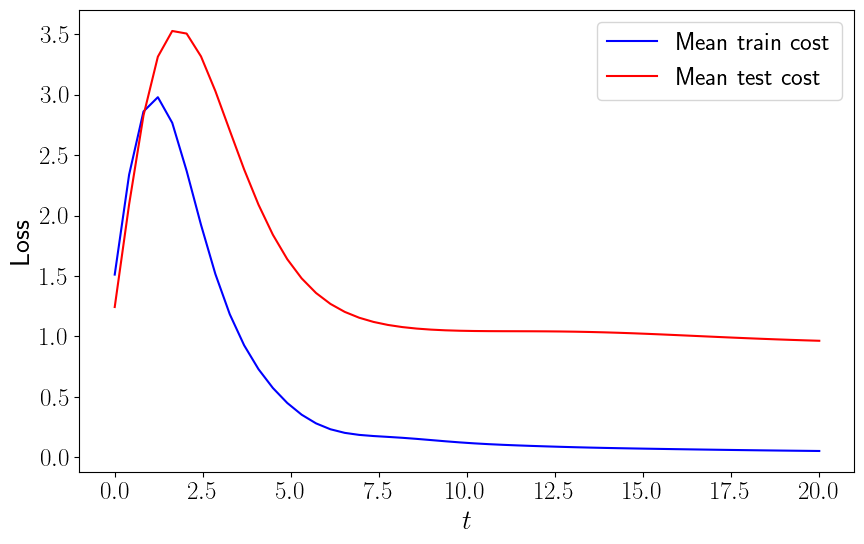

In [19]:
# set latex rendering
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.figure(figsize=(10, 6))
plt.plot(ts, train_cost, label='Mean train cost', color='blue')
plt.plot(ts, test_cost, label='Mean test cost', color='red')

plt.xlabel(r'$t$', fontsize=20)
plt.ylabel(r'Loss', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.savefig('figs/mnist_potential_energy.pdf', bbox_inches='tight')

In [12]:
costs = sde.cost(ys_gen[:, 0, :]).detach().numpy()

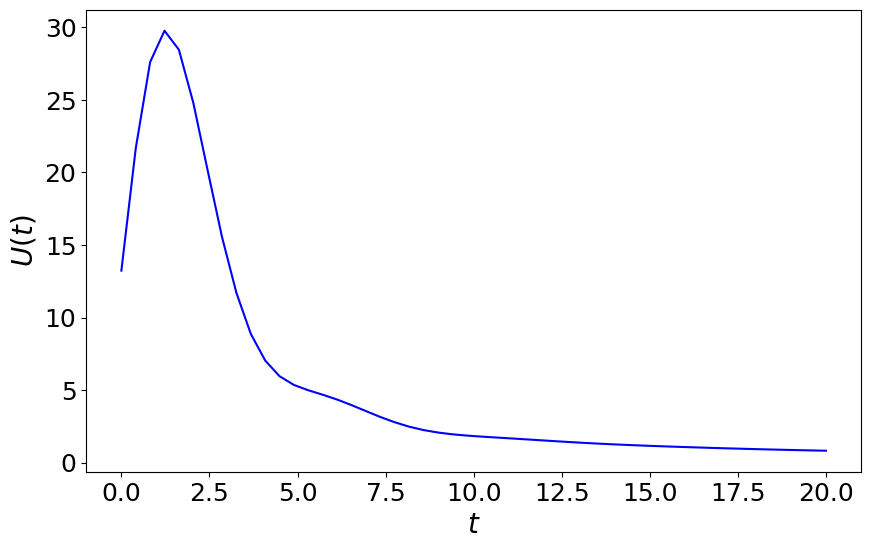

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(ts, costs, label='Mean Cost', color='blue')
# plt.fill_between(ts, mean_costs - std_costs, mean_costs + std_costs, color='blue', alpha=0.2)
plt.xlabel(r'$t$', fontsize=20)
plt.ylabel(r'$U(t)$', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('figs/mnist_potential_energy.pdf', bbox_inches='tight')